# CONTENT BASED FILTERING
Content based filtering berdasarkan pada data aktivitas, kategori, serta rating destinasi wisata. Sistem ini merekomendasikan destinasi wisata berdasarkan destinasi yang pernah dikunjungi atau diklik pengguna. Pengguna diberikan rekomendasi dengan aktivitas yang mirip dengan destinasi wisata sebelumnya.

**Import Libraries**

In [12]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

**Download Natural Language Toolkit (NLTK) untuk Data Prepocessing**

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Load Data**

In [14]:
# URL ke data JSON
url = 'https://raw.githubusercontent.com/acoramadan/Paradisata/CC/Database/Tourism_place/places_by_city.json'

# Memuat data JSON dari URL
response = requests.get(url)
data = json.loads(response.text)

# Mengubah JSON menjadi DataFrame
data = pd.DataFrame(data)

# Cek data
data.head()

,id_place,kategori,nama,foto,tentang,alamat,fasilitas,aktivitas,rating,ulasan,harga,jam_buka
0,1,Wisata Alam,Tangkuban Perahu,[https://raw.githubusercontent.com/acoramadan/...,Tangkuban Perahu adalah gunung berapi aktif ya...,"Cikahuripan, Kecamatan Lembang, Kabupaten Band...","[Parkir, Toilet, Warung makan, Area foto]","[Hiking, Fotografi, Menikmati pemandangan]",4.7,"[{'user': 'Ika', 'komentar': 'Tempat yang sang...","Rp 20,000",08:00 - 17:00
1,2,Wisata Sejarah,Museum Geologi,[https://raw.githubusercontent.com/acoramadan/...,Museum Geologi Bandung menawarkan koleksi geol...,"Jl. Diponegoro No.57, Cihaur Geulis, Kec. Cibe...","[Toilet, Area parkir, Pemandu wisata]","[Mengunjungi pameran geologi, Mempelajari fosi...",4.6,"[{'user': 'Rina', 'komentar': 'Tempat yang san...","Rp 10,000",08:00 - 16:00
2,3,Wisata Kuliner,Kedai Kopi 88,[https://raw.githubusercontent.com/acoramadan/...,Kedai Kopi 88 adalah tempat yang menawarkan be...,"Jl. Progo No. 88, Bandung, Jawa Barat","[Area parkir, Wi-Fi, Toilet, Tempat duduk luar]","[Mencicipi kopi, Menikmati suasana kedai, Berk...",4.8,"[{'user': 'Dewi', 'komentar': 'Kopinya sangat ...","Rp 25,000",09:00 - 22:00
3,4,Wisata Religi,Masjid Raya Bandung,[https://raw.githubusercontent.com/acoramadan/...,Masjid Raya Bandung adalah masjid terbesar di ...,"Jl. Dalem Kaum No.14, Balonggede, Kec. Regol, ...","[Toilet, Tempat parkir, Area ziarah]","[Beribadah, Ziarah, Fotografi arsitektur]",4.9,"[{'user': 'Ali', 'komentar': 'Masjid yang sang...",Gratis,24 Jam
4,5,Wisata Alam,Kawah Cibuni,[https://raw.githubusercontent.com/acoramadan/...,Kawah Cibuni adalah kawah vulkanik yang terlet...,"Patengan, Rancabali, Lembang, Bandung, Jawa Barat","[Tempat parkir, Warung makan, Toilet]","[Fotografi, Menikmati pemandangan kawah, Berja...",4.5,"[{'user': 'Benny', 'komentar': 'Pemandangannya...","Rp 15,000",08:00 - 16:00


**Data Prepocessing**

In [15]:
# Membuat custom stopwords untuk menyaring data
custom_stopwords = set(stopwords.words('indonesian') + ["wisata", "menikmati", "di", "dan", "dengan", "yang", "mengunjungi", "bersama", "mencicipi", "menjelajahi", "menonton", "mengikuti", "kegiatan"])

# Memproses teks
def preprocess_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in custom_stopwords]
    return ' '.join(tokens)

# Apply processess_text ke kolom kategori dan aktivitas
for col in ['kategori', 'aktivitas']:
    data[col] = data[col].apply(preprocess_text)

# Cek Data
data[:5]

,id_place,kategori,nama,foto,tentang,alamat,fasilitas,aktivitas,rating,ulasan,harga,jam_buka
0,1,alam,Tangkuban Perahu,[https://raw.githubusercontent.com/acoramadan/...,Tangkuban Perahu adalah gunung berapi aktif ya...,"Cikahuripan, Kecamatan Lembang, Kabupaten Band...","[Parkir, Toilet, Warung makan, Area foto]",hiking fotografi pemandangan,4.7,"[{'user': 'Ika', 'komentar': 'Tempat yang sang...","Rp 20,000",08:00 - 17:00
1,2,sejarah,Museum Geologi,[https://raw.githubusercontent.com/acoramadan/...,Museum Geologi Bandung menawarkan koleksi geol...,"Jl. Diponegoro No.57, Cihaur Geulis, Kec. Cibe...","[Toilet, Area parkir, Pemandu wisata]",pameran geologi mempelajari fosil fotografi mu...,4.6,"[{'user': 'Rina', 'komentar': 'Tempat yang san...","Rp 10,000",08:00 - 16:00
2,3,kuliner,Kedai Kopi 88,[https://raw.githubusercontent.com/acoramadan/...,Kedai Kopi 88 adalah tempat yang menawarkan be...,"Jl. Progo No. 88, Bandung, Jawa Barat","[Area parkir, Wi-Fi, Toilet, Tempat duduk luar]",kopi suasana kedai berkumpul teman,4.8,"[{'user': 'Dewi', 'komentar': 'Kopinya sangat ...","Rp 25,000",09:00 - 22:00
3,4,religi,Masjid Raya Bandung,[https://raw.githubusercontent.com/acoramadan/...,Masjid Raya Bandung adalah masjid terbesar di ...,"Jl. Dalem Kaum No.14, Balonggede, Kec. Regol, ...","[Toilet, Tempat parkir, Area ziarah]",beribadah ziarah fotografi arsitektur,4.9,"[{'user': 'Ali', 'komentar': 'Masjid yang sang...",Gratis,24 Jam
4,5,alam,Kawah Cibuni,[https://raw.githubusercontent.com/acoramadan/...,Kawah Cibuni adalah kawah vulkanik yang terlet...,"Patengan, Rancabali, Lembang, Bandung, Jawa Barat","[Tempat parkir, Warung makan, Toilet]",fotografi pemandangan kawah berjalan jalan,4.5,"[{'user': 'Benny', 'komentar': 'Pemandangannya...","Rp 15,000",08:00 - 16:00


Feature extraction

In [16]:
# Mengubah data kategori dan aktivitas ke array
vectorizer = TfidfVectorizer(max_features=5000)
kategori_tfidf = vectorizer.fit_transform(data['kategori']).toarray()
aktivitas_tfidf = vectorizer.fit_transform(data['aktivitas']).toarray()

# Normalisasi data rating
scaler = MinMaxScaler()
rating_scaled = scaler.fit_transform(data[['rating']].values)

# Menggabungkan seluruh fitur
features_combined = np.hstack([kategori_tfidf, aktivitas_tfidf, rating_scaled])

**Split Data**

In [17]:
# Menghitung panjang data
num_stories = len(data)

# Mendapatkan label kategori dari kolom 'nama' dan melakukan encoding
train_labels = data['nama']
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)  # Encode label menjadi format numerik

# Mengonversi label yang telah diencoding menjadi format one-hot encoding
train_labels_encoded = to_categorical(train_labels_encoded, num_classes=num_stories)

# Membagi dataset menjadi data pelatihan dan data validasi (80% untuk pelatihan, 10% untuk validasi)
x_train, x_val, y_train, y_val = train_test_split(features_combined, train_labels_encoded, test_size=0.1, random_state=42)


**Definisi Model**

In [18]:
# Model
input_shape = features_combined.shape[1]
input_text = Input(shape=(input_shape,))
x = Dense(128, activation='relu')(input_text)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(num_stories, activation='softmax')(x)
model = Model(inputs=input_text, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menambahkan early stopping untuk menghentikan epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Melatih model
history = model.fit(
    features_combined,
    train_labels_encoded,
    epochs=200,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0000e+00 - loss: 4.9627 - val_accuracy: 0.0000e+00 - val_loss: 4.9547
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0036 - loss: 4.9557 - val_accuracy: 0.0000e+00 - val_loss: 4.9521
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0036 - loss: 4.9473 - val_accuracy: 0.0000e+00 - val_loss: 4.9481
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0047 - loss: 4.9392 - val_accuracy: 0.0000e+00 - val_loss: 4.9429
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0103 - loss: 4.9303 - val_accuracy: 0.0000e+00 - val_loss: 4.9365
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0377 - loss: 4.9154 - val_accuracy: 0.0000e+00 - val_loss: 4.9274
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0380 - loss: 4.9034 - val_accuracy: 0.0000e+00 - val_loss: 4.9169
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0180 - loss: 4.8902 - 

Menghitung Cosine Similarity

In [19]:
def compute_cosine_similarity(features):
    # Normalisasi fitur untuk menghitung cosine similarity
    normalized_features = tf.nn.l2_normalize(features, axis=1)
    cosine_similarity = tf.matmul(normalized_features, normalized_features, transpose_b=True)
    return cosine_similarity

# Mendapatkan fitur cerita (misalnya, dari model Anda)
features = model.predict(features_combined)

# Menghitung cosine similarity antar cerita
cosine_sim = compute_cosine_similarity(features)

# Menampilkan rekomendasi berdasarkan cosine similarity
test_destination_idx = 8
similarities = cosine_sim[test_destination_idx]
top_indices = tf.argsort(similarities, direction='DESCENDING')[1:5]

print("Destinasi yang direkomendasikan untuk destinasi dengan ID", test_destination_idx, (data.iloc[test_destination_idx]['nama']),":")
for idx in top_indices:
    # Convert idx to a NumPy integer before using it for indexing
    idx_np = idx.numpy()
    print(data.iloc[idx_np]['nama'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Destinasi yang direkomendasikan untuk destinasi dengan ID 8 Curug Cimahi :
Curug Cikaso
Curug Sawer
Vihara Dharma Giri
Taman Wisata Alam Leuwi Hejo


Simpan model dalam h5 dan tflite

In [20]:
# Simpan model dalam format .h5
model.save('tourism_recommendation_model.h5')

# Ubah model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model dalam file .tflite
with open('tourism_recommendation_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp2wkc74ag'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 192), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 143), dtype=tf.float32, name=None)
Captures:
  140402167053152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167114992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167112176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167114816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167118160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167117280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167116048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167218240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167220176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140402167219824: TensorSpec(shape=(), dtype=tf.resource, name=None)


Plot model, loss, dan accuracy

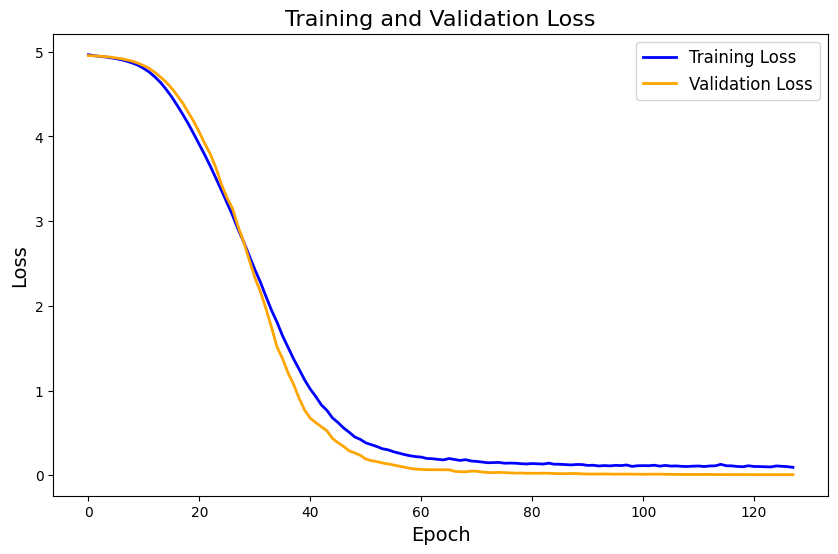

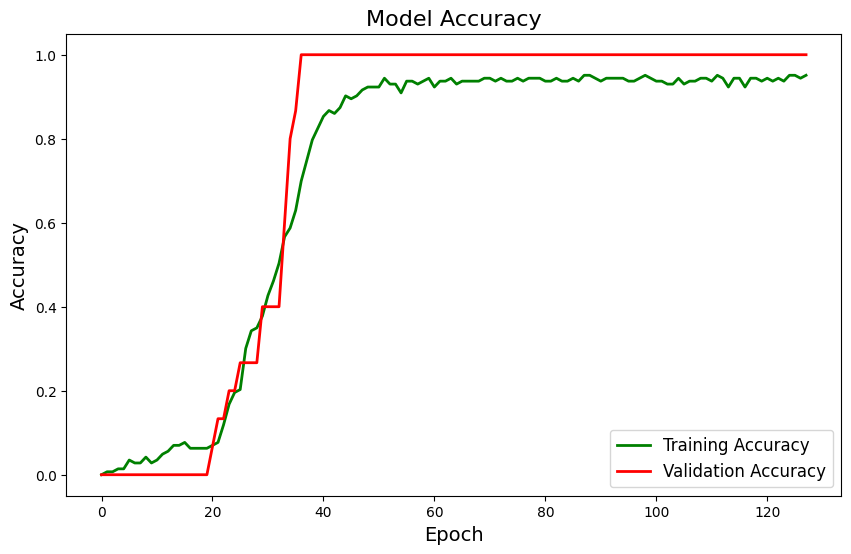

In [21]:
# Plot Model Structure
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)  # Save model structure plot

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss", color="blue", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange", linewidth=2)
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.savefig('training_validation_loss.png')  # Save the plot
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color="green", linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="red", linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('accuracy_plot.jpg')
plt.show()